# Apache Arrow

## step 1

We need to convert your data to parquet. Parquet stores data across columns rather than rows. It's lighter, faster (better?). It's also what many cloud computing systems use under the hood—so it must be good. To convert your files to parquet, just read them in using `dask` or `pandas`.

In [7]:
import dask.dataframe as dd
# this should whatever your locomizer data file is
#%time temp = dd.read_csv("../data/sample/signals_set_2.csv")
%time temp = dd.read_csv("working.csv")
%time temp.head()

CPU times: user 25.4 ms, sys: 1.96 ms, total: 27.4 ms
Wall time: 27.2 ms
CPU times: user 2.46 s, sys: 278 ms, total: 2.74 s
Wall time: 4.24 s


,Unnamed: 0,userid,file,lat,lon,date,hour
0,0,6E18919F970B7AEEBC3220A26DEEFB6E,2020-02-13_2020-02-27,51.518097,-0.103170,2020/2/13,8
1,1,51177A9844225874313BBD094498054D,2020-02-13_2020-02-27,51.511474,-0.083429,2020/2/13,14
2,2,51177A9844225874313BBD094498054D,2020-02-13_2020-02-27,51.510780,-0.085580,2020/2/13,16
3,3,51177A9844225874313BBD094498054D,2020-02-13_2020-02-27,51.511470,-0.083447,2020/2/13,14
4,4,170956F9890CB8855DF32854F1B871E2,2020-02-13_2020-02-27,51.503170,-0.112834,2020/2/13,9


In [8]:
temp

,Unnamed: 0,userid,file,lat,lon,date,hour
npartitions=1,,,,,,,
,int64,object,object,float64,float64,object,int64
,...,...,...,...,...,...,...


In [9]:
min = temp.lat.min()
max = temp.lat.max()

In [10]:
%time print(min.compute())
%time print(max.compute())

51.486269
CPU times: user 1.5 s, sys: 137 ms, total: 1.63 s
Wall time: 1.63 s
51.5318211
CPU times: user 1.45 s, sys: 48.3 ms, total: 1.5 s
Wall time: 1.5 s


In [11]:
import pandas as pd
%time temp = temp.compute()
# save it wherever you want to save the new files
#%time temp.to_parquet("../data/sample/signals_set_2.parquet")
%time temp.to_parquet("working.parquet")

CPU times: user 2.4 s, sys: 91.1 ms, total: 2.49 s
Wall time: 2.49 s
CPU times: user 2.35 s, sys: 83.3 ms, total: 2.44 s
Wall time: 2.79 s


# step 2
Let's set some bounds. We can make the data more manageable by clipping it to the ULEZ. 

In [12]:
# download the shape for ULEZ
import geopandas as gpd
zone = gpd.read_file("https://data.london.gov.uk/download/ultra_low_emissions_zone/3d980a29-c340-4892-8230-ed40d8c7f32d/Ultra_Low_Emissions_Zone.json")
zone = zone.bounds
zone

,minx,miny,maxx,maxy
0,-0.167077,51.486268,-0.072136,51.531821


In [13]:
# get bounds
x_range = (zone.minx[0], zone.maxx[0])
y_range = (zone.miny[0], zone.maxy[0])

In [14]:
# load in your folder with locomizer traces
import os
import re
#files = os.listdir("../data/traces/")
files = os.listdir("./")
files.sort()

In [19]:
files

['.DS_Store',
 '.ipynb_checkpoints',
 '2020-03-13-uk-covid19-could-cause-permanent-shift-towards-home-working.pdf',
 '3_FormA_Screening-Form.pdf',
 '3_FormA_Screening.docx',
 '3_FormA_Screening_Zhuoran.docx',
 '3_FormA_Screening_Zhuoran.pdf',
 '694325_Philip_Wilkinson_Final_dissertation_1612843_1855428034.pdf',
 '9781315684284_previewpdf.pdf',
 'Abstract.docx',
 'Abstract.pdf',
 'Agglomeration.bib',
 'CASA Dissertation Handbook.pdf',
 'Citations',
 'FAME',
 'Industry and Innovation submission zh.docx',
 'Industry and Innovation submission.docx',
 'L1.pdf',
 'Literature_points_Zhuoran.docx',
 'My Library.bib',
 'PATENTS',
 'Project15.docx',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Zhuoran_Liu.pptx',
 'Zhuoran_Liu_dissertation.docx',
 'arrow.ipynb',
 'dissertation.bib',
 'f_lit_rev zh.docx',
 'f_lit_rev.docx',
 'file.csv',
 'locomizer.yml',
 'proposal.docx',
 's11356-021-12858-1.pdf',
 'traces.csv',
 'working.csv',
 'working.parquet',
 '~$lit_rev的副本.docx',
 '截屏2023-04-06 12.57.08.png',
 

In [20]:
# choose a single file to play around with
file = files[-4]
file

'working.parquet'

In [21]:
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.feather as ft

In [23]:
# let's filter just 1 week of the data to make it easier to work with
from datetime import timedelta, datetime

In [36]:
dates = re.findall("[0-9]+-[0-9]+-[0-9]+", file)
start = datetime.strptime(dates[0], '%Y-%m-%d').date()
delta = start + timedelta(days=7)

In [30]:
start = datetime.strptime("2020-02-13",'%Y-%m-%d').date()
delta = start + timedelta(days=7)

In [32]:
type(delta)

datetime.date

In [33]:
# so we apply these filters, bounds and date
month = pq.read_table(f"./{file}", 
                          filters=[
                              ("lon", ">", x_range[0]),
                              ("lon", "<", x_range[1]), 
                              ("lat", ">", y_range[0]), 
                              ("lat", "<", y_range[1])
                              # ,("date", "<", delta)
                          ])

In [34]:
# the data is not stored in memory
month

pyarrow.Table
Unnamed: 0: int64
userid: string
file: string
lat: double
lon: double
date: string
hour: int64
----
Unnamed: 0: [[0,1,2,3,4,...,131067,131068,131069,131070,131071],[131072,131073,131074,131075,131076,...,262139,262140,262141,262142,262143],...,[393216,393217,393218,393219,393220,...,524283,524284,524285,524286,524287],[524288,524289,524290,524291,524292,...,552447,552448,552449,552450,552451]]
userid: [["6E18919F970B7AEEBC3220A26DEEFB6E","51177A9844225874313BBD094498054D","51177A9844225874313BBD094498054D","51177A9844225874313BBD094498054D","170956F9890CB8855DF32854F1B871E2",...,"F24007273EE7DF4F76E79C1EA8937596","6455373789B63BAF70B16C0BF96355A8","6455373789B63BAF70B16C0BF96355A8","E1F234DEDCC21274155169B93DCD268A","B46A087634E10EF8FBE6E6D128BCB4AD"],["742D6275A60822EC5E787A3481654E7E","29D6D1C743119B96243F6D3EF0D57F52","C52B7F9A7A0340B1A63B4C02B3F9D4B0","1769282C38313DB6DF15D19D0ADE03C8","1769282C38313DB6DF15D19D0ADE03C8",...,"754CB5E9661DDAEF83A0D0F5EB37F4A4","36F6A5D6

In [39]:
# but you can see we've gotten the observations down to 5 million
month.shape

(5725533, 6)

In [35]:
# use pyarrow to read in the userid column and store it as a pd.Series
%time userids = month.column("userid").to_pandas()

CPU times: user 147 ms, sys: 893 µs, total: 148 ms
Wall time: 145 ms


In [36]:
import pyarrow as pa
import numpy as np
import pandas as pd

In [37]:
# we can do better by throwing out bad devices
userids = pd.DataFrame(userids).groupby("userid", as_index=False).size().sort_values('size', ascending=False)
userids.head()

,userid,size
3372,21807E669444D04730DC9CD3DE6F2D42,177
21375,D80D578D08D91B90D9E8BB3F77BBDFA2,175
17557,B1812CB6158DCB9CE7161461B32D0198,169
7081,46E49A77DFA1FB36FB55B37C2E202CB1,168
4424,2C7EB3B6F5DF3D16B7E2B28383D79300,167


In [60]:
# a lot of these devices have 1 observation, so we can throw them out
userids.tail()

,userid,size
57745,A9CAB39489F39A1DC087FCAD8A4ADE19,1
32203,5EDCAB00413A99840A9EEC3EEE50BEBF,1
32204,5EDDCFE8FB3CDF95654FF031EDA93B44,1
57739,A9C61857FE725C887541032B6C7FBF44,1
75494,DD84899728E20B39881409B4037E18EC,1


In [38]:
# but why don't we also get rid of all devices at the extreme so our sample is more consistent
userids['decile'] = pd.qcut(userids['size'], 10, labels=False)
# throw out bottom and top decile
userids = userids[(userids.decile > 0) & (userids.decile < 9)]
userids.head()

,userid,size,decile
4749,2F78401B86B710B79335E32FBA0E1BC0,49,8
15798,9F2697D32D5CCC58C67DA3F030151EA1,49,8
24575,F840404DBF68D96030F3529CF9340906,49,8
1570,0F7BA750FEA5C86E3DE67DA469D1C6A3,49,8
4687,2EE642F059D14FAF065FBFDAF84CD5D9,49,8


In [39]:
# we can just stack this onto our existing filter
sample = month.filter(pc.is_in(month['userid'], 
                                pa.array(userids.userid)
                               )
                      )

In [40]:
# down to 2 million observations
sample.shape

(374470, 7)

In [41]:
# we can save the trimmed data 
%time pq.write_table(month, "working_new.parquet")

CPU times: user 876 ms, sys: 38.9 ms, total: 915 ms
Wall time: 1.47 s


In [114]:
# or we can trim it down further...
trimmed = sample.filter(pc.equal(sample['date'], pa.scalar(start)))

# ...so that we can pull it into pandas
%time trimmed = trimmed.to_pandas()

CPU times: user 104 ms, sys: 51.9 ms, total: 156 ms
Wall time: 246 ms


In [116]:
trimmed.shape

(552452, 6)

In [ ]:
# # it's not hard to wrap everything we did into a function and iterate over all days with whatever analysis you want to do
# def get_users(table):
#     userids = table.column("userid").to_pandas()
#     userids = pd.DataFrame(userids).groupby("userid", as_index=False).size().sort_values('size', ascending=False)
#     userids['decile'] = pd.qcut(userids['size'], 10, labels=False)
#     userids = userids[(userids.decile > 0) & (userids.decile < 9)]
    
#     return userids

# def grab_tracks(file, x_range, y_range, days=7):
#     from datetime import timedelta, datetime
#     dates = re.findall("[0-9]+-[0-9]+-[0-9]+", file)
#     start = datetime.strptime(dates[0], '%Y-%m-%d').date()
#     delta = start + datetime.timedelta(days=days)
#     month = pq.read_table(f"../data/traces/{file}", 
#                           filters=[
#                               ("lon", ">", x_range[0]),
#                               ("lon", "<", x_range[1]), 
#                               ("lat", ">", y_range[0]), 
#                               ("lat", "<", y_range[1]), 
#                               ("date", "<", delta)
#                           ])
    
#     userids = get_users(month)
#     # we can just stack this onto our existing filter
#     sample = month.filter(pc.is_in(month['userid'], pa.array(userids.userid)))
    
#     pq.write_table(sample, f"../data/working/trimmed_{file}")

#     return sample


In [ ]:
# then we just iterate over the files (or days within each file) 
for file in files:

    first = grab_tracks(file, x_range=x_range, y_range=y_range, days=7)
    # now run the analysis that you want 
    # you would need to add some code here to iterate across days with each file

# Back to Dask

One cool thing about `dask` is that it plays well `datashader`, a tool for building visuals with large datasets by aggregating to a raster

In [66]:
locomizer = dd.read_csv("working.csv")
locomizer

,userid,lat,lon,date,hour
npartitions=65,,,,,
,int64,float64,float64,object,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [67]:
# palettes  this is also a website of colors
import colorcet as cc
#datashader also for network

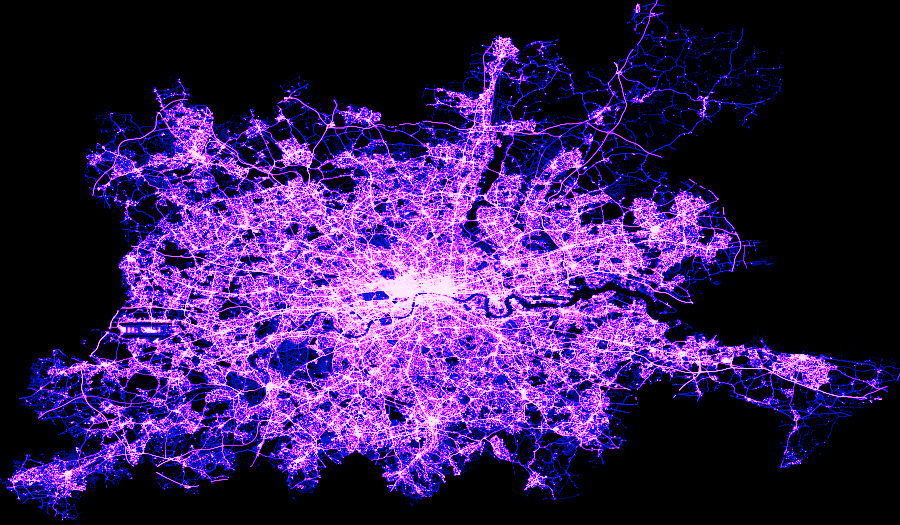

In [69]:
# define some a default plot width & height
plot_w  = int(900)
plot_h = int(plot_w*7.0/12)

# datashader imports
import datashader as ds
import datashader.transfer_functions as tf

# Step 1: Setup canvas
cvs = ds.Canvas(plot_width=plot_w, plot_height=plot_h)

# Step 2: Aggregate to raster
agg = cvs.points(locomizer, "lon", "lat", agg=ds.count())

# Step 3: Shade and set background
img = tf.shade(agg, cmap=cc.bmw, how="eq_hist")
img = tf.set_background(img, "black")

img

In [106]:
# add a column to the dask dataframe that flags whether or the hour value is higher than 8 and lower than 18
locomizer['wday'] = (locomizer['hour'] > 8) & (locomizer['hour'] < 18)
# replace True with "day" and False with "night"
locomizer['wday'] = locomizer['wday'].replace({True: "day", False: "night"})
# make it a categorical variable
locomizer['wday'] = locomizer['wday'].astype("category")

In [107]:
locomizer.head()

,userid,lat,lon,date,hour,wday
0,3241829976181573491,51.521712,-0.047056,2020-02-13,11,day
1,4276982062519938009,51.521971,-0.046572,2020-02-13,16,day
2,3771634320098074661,51.521690,-0.047084,2020-02-13,14,day
3,-8316385956250653739,51.469348,0.119686,2020-02-13,15,day
4,-5319499157713704227,51.521621,-0.043450,2020-02-13,7,night


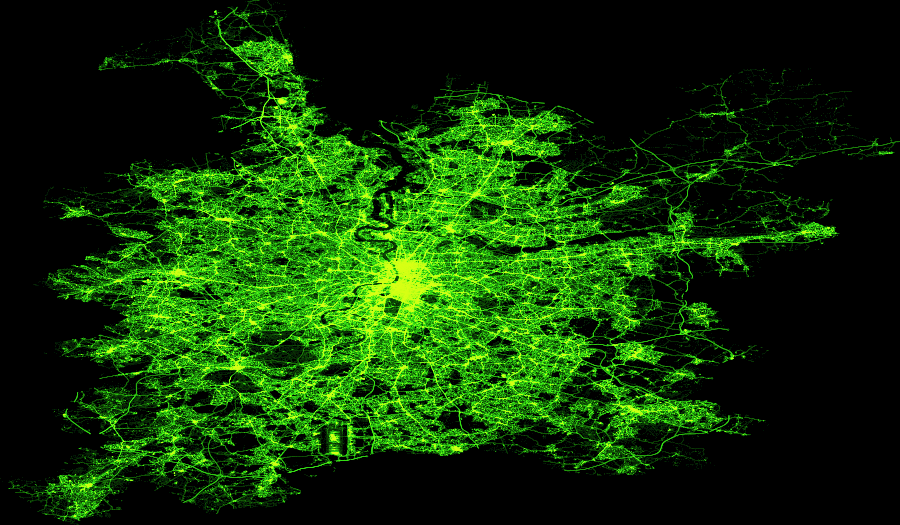

In [110]:
ddf = locomizer[locomizer['wday'] == "day"]

cvs = ds.Canvas(plot_width=plot_w, plot_height=plot_h)
agd = cvs.points(ddf, "lat", "lon", agg=ds.count())
img = tf.shade(agg, cmap=cc.kgy, how="eq_hist")
img = tf.set_background(img, "black")

img

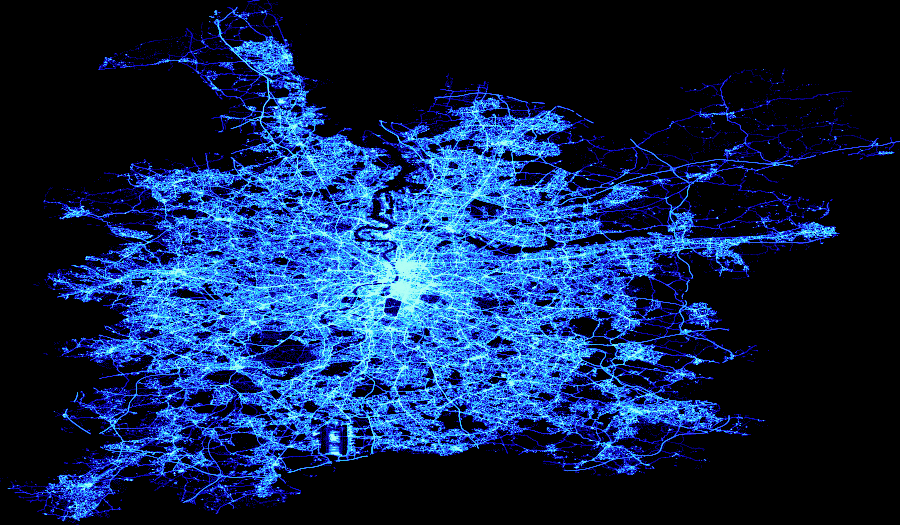

In [112]:
ddf = locomizer[locomizer['wday'] == "night"]

cvs = ds.Canvas(plot_width=plot_w, plot_height=plot_h)
agn = cvs.points(ddf, "lat", "lon", agg=ds.count())
img = tf.shade(agg, cmap=cc.kbc, how="eq_hist")
img = tf.set_background(img, "black")

img

# ...and a pointer for Dask Geopandas

Check out `dask_geopandas` if spatial operations are breaking your computer. [Here](https://dask-geopandas.readthedocs.io/en/stable/index.html).

In [101]:
# %time tracks = dd.read_csv('tracks.csv')

In [102]:
# import dask_geopandas as dg
# geotracks = tracks.set_geometry(dg.points_from_xy(tracks, x="X", y="Y", crs=4326))
# geotracks.head(n=10)

In [103]:
# from dask.distributed import Client, LocalCluster
# client = Client(
#     LocalCluster(
#         # how many cores do you want to use
#         n_workers=8, 
#         threads_per_worker=1
#     )
# )

In [ ]:
# joined = dg.sjoin(geotracks, GEODATAFRAME_TO_JOIN, predicate="within")
# joined = joined.compute()